# Evaporation from ZAMG data
*A. Kokimova, November 2021, University of Graz*

What is done:

- load the station data from ZAMG
- estimate potential evaporation
- plot and store results

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pyet
pyet.show_versions()

Python version: 3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]
Numpy version: 1.21.5
Scipy version: 1.7.3
Pandas version: 1.4.2
Matplotlib version: 3.5.1
Pyet version: 1.1.0b


## Loading daily data from ZAMG (Messstationen Tagesdaten)

station: Graz Universität 16412

Selected variables:
- globalstrahlung (global radiation), J/cm2 needs to be in MJ/m3d, ZAMG abbreviation - strahl
- arithmetische windgeschwindigkeit (wind speed), m/s, ZAMG abbreviation - vv
- relative feuchte (relative humidity), %, ZAMG abbreviation - rel
- lufttemparatur (air temperature) in 2 m, C, ZAMG abbreviation - t
- lufttemperatur (air temperature) max in 2 m, C, ZAMG abbreviation - tmax
- lufttemperatur (air temperature) min in 2 m, C, ZAMG abbreviation - tmin
- latitute and elevation of a station

In [2]:
#read data
data_16412 = pd.read_csv('data//klima_daily.csv', index_col=1, parse_dates=True)
data_16412

,station,strahl,rel,t,tmax,tmin,vv
time,,,,,,,
2000-01-01,16412,300.0,80.0,-2.7,0.5,-5.8,1.0
2000-01-02,16412,250.0,86.0,0.2,2.5,-2.1,1.0
2000-01-03,16412,598.0,86.0,0.6,3.6,-2.4,1.0
2000-01-04,16412,619.0,83.0,-0.5,4.5,-5.5,1.0
2000-01-05,16412,463.0,84.0,-0.1,5.4,-5.5,1.0
...,...,...,...,...,...,...,...
2021-11-07,16412,852.0,74.0,8.5,12.2,4.7,1.6
2021-11-08,16412,553.0,78.0,7.5,10.4,4.5,1.6
2021-11-09,16412,902.0,67.0,7.1,11.7,2.4,2.7


## Calculate PET for Graz Universität - 16412

In [3]:
# Convert Glabalstrahlung J/cm2 to MJ/m2 by dividing to 100

meteo = pd.DataFrame({"time":data_16412.index, "tmean":data_16412.t, "tmax":data_16412.tmax, "tmin":data_16412.tmin, "rh":data_16412.rel, 
                      "wind":data_16412.vv, "rs":data_16412.strahl/100})
time, tmean, tmax, tmin, rh, wind, rs = [meteo[col] for col in meteo.columns]

lat = 47.077778*np.pi/180  # Latitude of the meteorological station, converting from degrees to radians
elevation = 367  # meters above sea-level

# Estimate evaporation with four different methods and create a dataframe
pet_u = pd.DataFrame()
pet_u["pe_penman"] = pyet.penman(tmean, wind, rs=rs, elevation=elevation, lat=lat, tmax=tmax, tmin=tmin, rh=rh)
pet_u["pe_pt"] = pyet.priestley_taylor(tmean, wind, rs=rs, elevation=elevation, lat=lat, tmax=tmax, tmin=tmin, rh=rh)
pet_u["pe_makkink"] = pyet.makkink(tmean, rs, elevation=elevation)
pet_u["pe_fao56"] = pyet.pm_fao56(tmean, wind, rs=rs, elevation=elevation, lat=lat, tmax=tmax, tmin=tmin, rh=rh)
pet_u["pe_oudin"] = pyet.oudin(tmean, lat=lat)
pet_u

,pe_penman,pe_pt,pe_makkink,pe_fao56,pe_oudin
time,,,,,
2000-01-01,0.236181,0.166619,0.284784,0.290066,0.087023
2000-01-02,0.274056,0.241197,0.267085,0.304711,0.198423
2000-01-03,0.030843,-0.068118,0.648786,0.099883,0.215092
2000-01-04,0.041232,-0.075998,0.643382,0.123393,0.173807
2000-01-05,0.154848,0.070665,0.488891,0.217359,0.190662
...,...,...,...,...,...
2021-11-07,0.569201,0.382303,1.201930,0.803721,0.724575
2021-11-08,0.564209,0.440711,0.757774,0.730940,0.660937
2021-11-09,0.623685,0.246001,1.221325,1.142893,0.630708


### Plot results

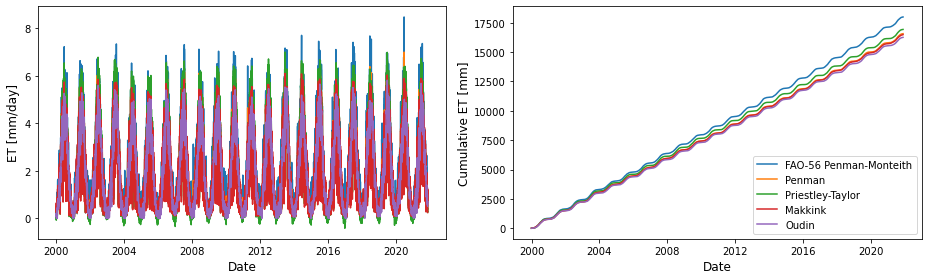

In [4]:
fig, axs = plt.subplots(figsize=(13,4), ncols=2)
axs[0].plot(pet_u['pe_fao56'], label = "FAO-56 Penman-Monteith")
axs[0].plot(pet_u['pe_penman'],label="Penman")
axs[0].plot(pet_u['pe_pt'], label="Priestley-Taylor")
axs[0].plot(pet_u['pe_makkink'], label="Makkink")
axs[0].plot(pet_u['pe_oudin'], label="Oudin")

axs[1].plot(pet_u['pe_fao56'].cumsum(), label="FAO-56 Penman-Monteith")
axs[1].plot(pet_u['pe_penman'].cumsum(),label="Penman")
axs[1].plot(pet_u['pe_pt'].cumsum(), label="Priestley-Taylor")
axs[1].plot(pet_u['pe_makkink'].cumsum(), label="Makkink")
axs[1].plot(pet_u['pe_oudin'].cumsum(), label="Oudin")

axs[0].set_ylabel("ET [mm/day]", fontsize=12)
axs[1].set_ylabel("Cumulative ET [mm]", fontsize=12)
for i in (0,1):
    axs[i].set_xlabel("Date", fontsize=12)

plt.tight_layout()
axs[1].legend(loc=4, fontsize=10)

### Store results

In [5]:
#plt.savefig("evap_16412.png", dpi=300)
#pet_u.to_csv('../evap_16412.csv')